Epoch [1/5] Loss: 0.048796


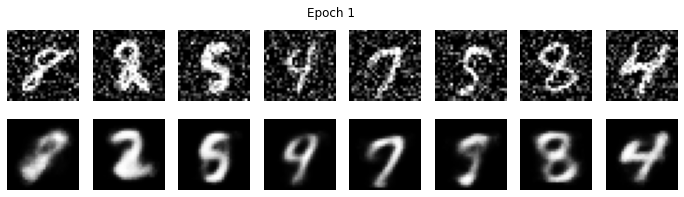

Epoch [2/5] Loss: 0.025295


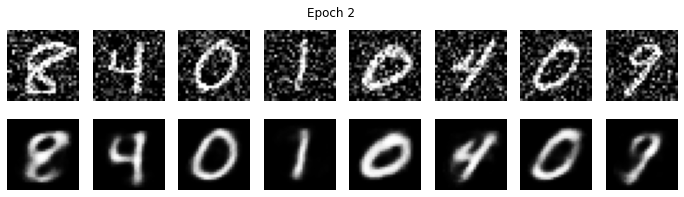

Epoch [3/5] Loss: 0.021428


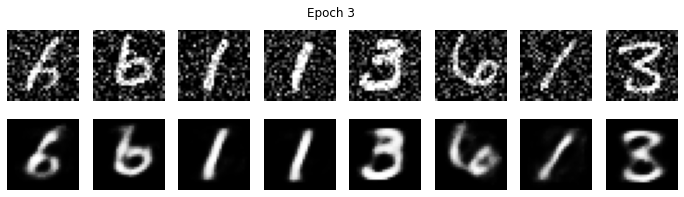

Epoch [4/5] Loss: 0.019768


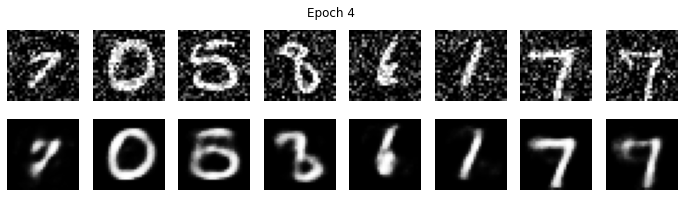

Epoch [5/5] Loss: 0.018696


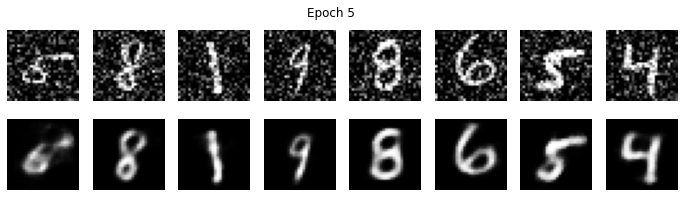

In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 128
LATENT_DIM = 32
EPOCHS = 5
NOISE_FACTOR = 0.3

data_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=data_transform,
    download=True
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

class AutoEncoder(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

def add_noise(x, noise_factor=0.3):
    noise = torch.randn_like(x) * noise_factor
    x_noisy = x + noise
    x_noisy = torch.clamp(x_noisy, 0., 1.)
    return x_noisy

model = AutoEncoder(LATENT_DIM).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()

for epoch in range(EPOCHS):
    total_loss = 0

    for x, _ in train_loader:
        x = x.view(-1, 784).to(device)
        x_noisy = add_noise(x, NOISE_FACTOR)

        optimizer.zero_grad()
        x_recon = model(x_noisy)
        loss = criterion(x_recon, x)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {avg_loss:.6f}")

    with torch.no_grad():
        x, _ = next(iter(train_loader))
        x = x.view(-1, 784).to(device)
        x_noisy = add_noise(x, NOISE_FACTOR)
        x_recon = model(x_noisy)

        n = 8
        plt.figure(figsize=(12, 3))

        for i in range(n):
            plt.subplot(2, n, i+1)
            plt.imshow(x_noisy[i].view(28, 28).cpu(), cmap="gray")
            plt.axis("off")

            plt.subplot(2, n, i+1+n)
            plt.imshow(x_recon[i].view(28, 28).cpu(), cmap="gray")
            plt.axis("off")

        plt.suptitle(f"Epoch {epoch+1}")
        plt.show()
